# Homework 5 - Part 1
## Deep Learning Technologies
### Shruti Badrinarayanan - 016768141

## Load the Data

We begin by downloading and importing the data as a PyTorch dataset using the `Fashion MNIST` helper class from `torchvision.datasets`.

In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

fashion_mnist = FashionMNIST(root='data',
                              train=True,
                              download=True,
                              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 26421880/26421880 [00:00<00:00, 121555874.71it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5247324.63it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 61204647.88it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17301504.00it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Note that we are are transforming the pixel values from the range `[0, 1]` to the range `[-1, 1]`. The reason for doing this will become clear when define the generator network. Let's look at a sample tensor from the data.

In [ ]:
img, label = fashion_mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

As expected, the pixel values range from -1 to 1. Let's define a helper to denormalize and view the images. This function will also be useful for viewing the generated images.

In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


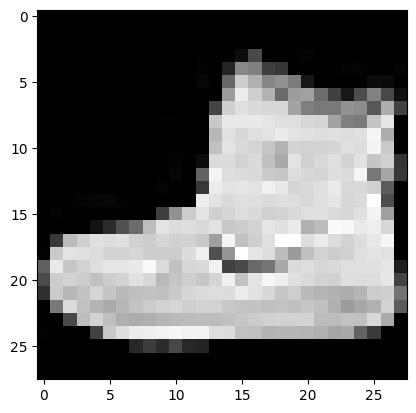

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

Finally, let's create a dataloader to load the images in batches.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([7, 6, 9, 4, 6, 6, 3, 4, 7, 5, 9, 4, 1, 0, 8, 3, 4, 4, 5, 5, 9, 0, 4, 3,
        4, 2, 1, 0, 0, 1, 0, 7, 4, 2, 6, 5, 0, 4, 1, 8, 6, 2, 9, 5, 1, 0, 5, 2,
        2, 4, 2, 5, 7, 0, 1, 1, 7, 9, 7, 9, 2, 0, 1, 2, 6, 5, 9, 5, 1, 5, 0, 0,
        5, 5, 8, 0, 0, 7, 2, 1, 0, 4, 2, 0, 8, 9, 1, 2, 6, 8, 1, 0, 1, 6, 6, 4,
        2, 1, 8, 4])


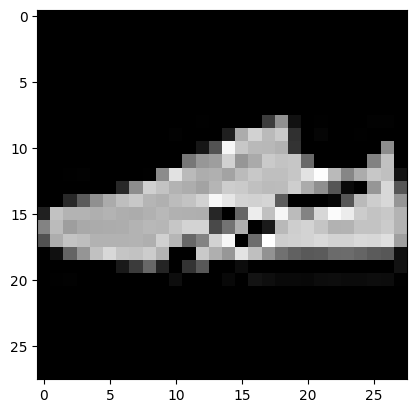

In [ ]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cpu')

## Discriminator Network

In [ ]:
image_size = 784
hidden_size = 256

In [ ]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [ ]:
D.to(device);

## Generator Network

In [ ]:
latent_size = 64

In [ ]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [ ]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

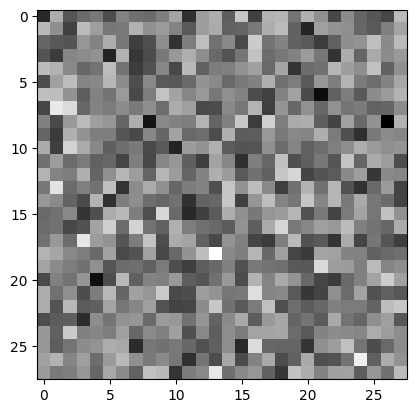

In [ ]:
plt.imshow(gen_imgs[0], cmap='gray');

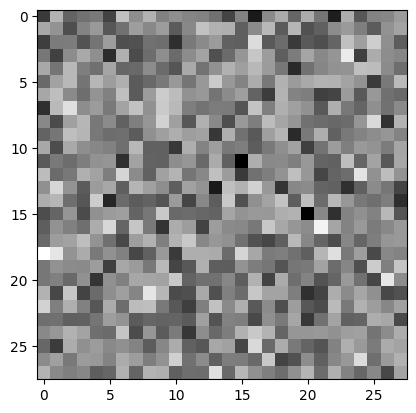

In [ ]:
plt.imshow(gen_imgs[1], cmap='gray');

In [ ]:
G.to(device);

## Discriminator Training

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [68]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(criterion, optimizer, discriminator_model, generator_model, images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = discriminator_model(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = generator_model(z)
    outputs = discriminator_model(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    optimizer.step()

    return d_loss, real_score, fake_score

## Generator Training

In [ ]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [69]:
def train_generator(criterion, optimizer, discriminator_model, generator_model):
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = generator_model(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(discriminator_model(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    optimizer.step()
    return g_loss, fake_images

## Training the Model

In [ ]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Let's save a batch of real images that we can use for visual comparision while looking at the generated images.

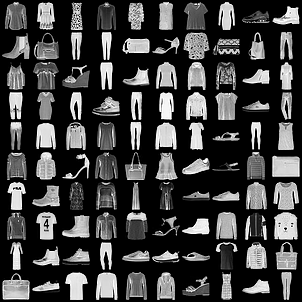

In [ ]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

We'll also define a helper function to save a batch of generated images to disk at the end of every epoch. We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model.

Saving fake_images-0000.png


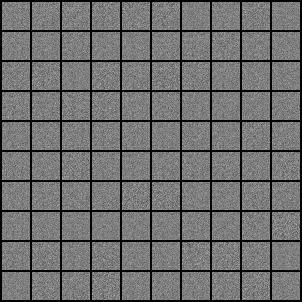

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

We are now ready to train the model. In each epoch, we train the discriminator first, and then the generator. The training might take a while if you're not using a GPU.

In [ ]:
%%time

num_epochs = 50
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(D, G, images)
        g_loss, fake_images = train_generator(G)

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/50], Step [200/600], d_loss: 0.0077, g_loss: 6.5685, D(x): 1.00, D(G(z)): 0.01
Epoch [0/50], Step [400/600], d_loss: 0.0726, g_loss: 6.6576, D(x): 0.99, D(G(z)): 0.04
Epoch [0/50], Step [600/600], d_loss: 0.0302, g_loss: 9.9027, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0001.png
Epoch [1/50], Step [200/600], d_loss: 0.0457, g_loss: 5.2566, D(x): 0.99, D(G(z)): 0.01
Epoch [1/50], Step [400/600], d_loss: 0.0297, g_loss: 8.3386, D(x): 0.99, D(G(z)): 0.01
Epoch [1/50], Step [600/600], d_loss: 0.1116, g_loss: 9.1473, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0002.png
Epoch [2/50], Step [200/600], d_loss: 0.0440, g_loss: 5.7134, D(x): 0.99, D(G(z)): 0.02
Epoch [2/50], Step [400/600], d_loss: 0.0895, g_loss: 5.8758, D(x): 0.98, D(G(z)): 0.04
Epoch [2/50], Step [600/600], d_loss: 0.0494, g_loss: 6.5419, D(x): 0.99, D(G(z)): 0.03
Saving fake_images-0003.png
Epoch [3/50], Step [200/600], d_loss: 0.1140, g_loss: 4.8728, D(x): 0.99, D(G(z)): 0.08
Epoch [3/50], Step [400/600], d_loss

Now that we have trained the models, we can save checkpoints.

In [45]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Here's how the generated images look, after the 1st, 5th, 10th and 25th epochs of training.

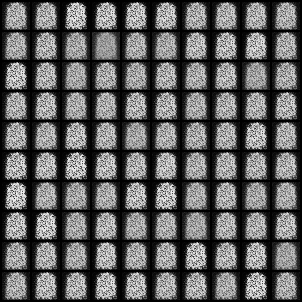

In [46]:
Image('./samples/fake_images-0001.png')

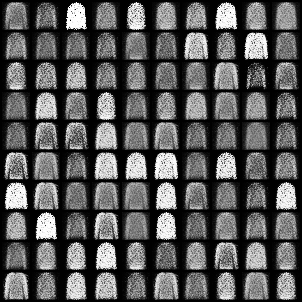

In [47]:
Image('./samples/fake_images-0005.png')

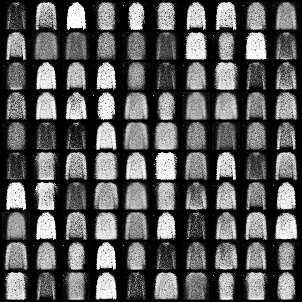

In [48]:
Image('./samples/fake_images-0010.png')

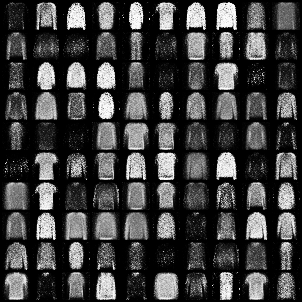

In [49]:
Image('./samples/fake_images-0025.png')

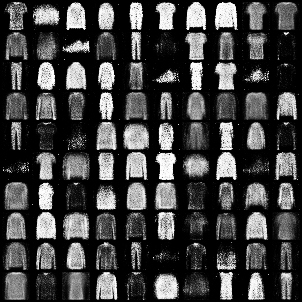

In [50]:
Image('./samples/fake_images-0050.png')

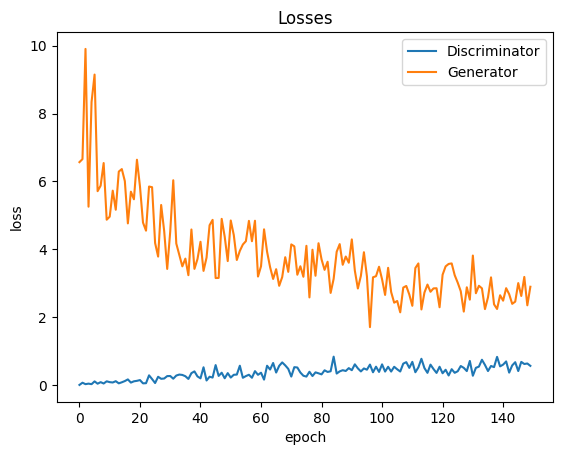

In [51]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

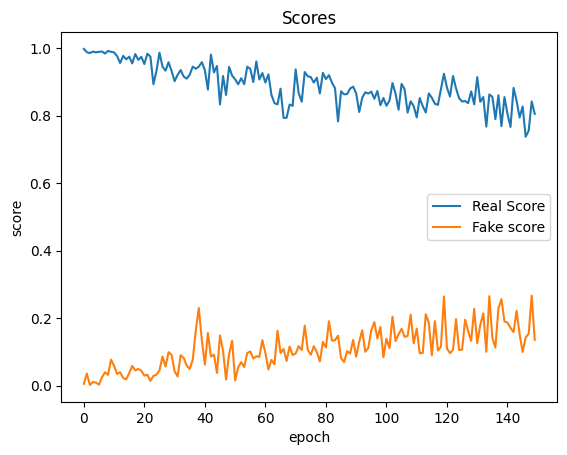

In [52]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [53]:
D_loaded = D
D_loaded.load_state_dict(torch.load('D.ckpt'))
D_loaded.eval()

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [54]:
G_loaded = G
G_loaded.load_state_dict(torch.load('G.ckpt'))
G_loaded.eval()

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [56]:
%%time

num_epochs = 20
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(D_loaded, G_loaded, images)
        g_loss, fake_images = train_generator(G_loaded)

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/20], Step [200/600], d_loss: 0.6035, g_loss: 2.6312, D(x): 0.83, D(G(z)): 0.21
Epoch [0/20], Step [400/600], d_loss: 0.6754, g_loss: 2.8216, D(x): 0.81, D(G(z)): 0.20
Epoch [0/20], Step [600/600], d_loss: 0.3828, g_loss: 3.2493, D(x): 0.87, D(G(z)): 0.11
Saving fake_images-0001.png
Epoch [1/20], Step [200/600], d_loss: 0.5016, g_loss: 3.1242, D(x): 0.80, D(G(z)): 0.15
Epoch [1/20], Step [400/600], d_loss: 0.4353, g_loss: 2.6845, D(x): 0.88, D(G(z)): 0.18
Epoch [1/20], Step [600/600], d_loss: 0.7018, g_loss: 2.5040, D(x): 0.74, D(G(z)): 0.16
Saving fake_images-0002.png
Epoch [2/20], Step [200/600], d_loss: 0.7791, g_loss: 1.7939, D(x): 0.80, D(G(z)): 0.28
Epoch [2/20], Step [400/600], d_loss: 0.7415, g_loss: 2.4369, D(x): 0.81, D(G(z)): 0.23
Epoch [2/20], Step [600/600], d_loss: 0.5751, g_loss: 2.4881, D(x): 0.85, D(G(z)): 0.22
Saving fake_images-0003.png
Epoch [3/20], Step [200/600], d_loss: 0.5662, g_loss: 2.7613, D(x): 0.78, D(G(z)): 0.12
Epoch [3/20], Step [400/600], d_loss

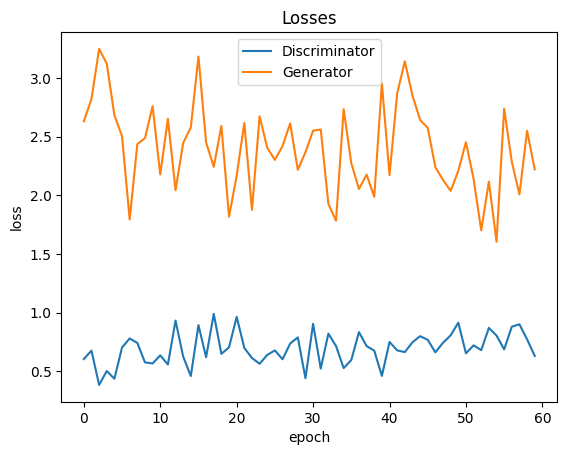

In [57]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

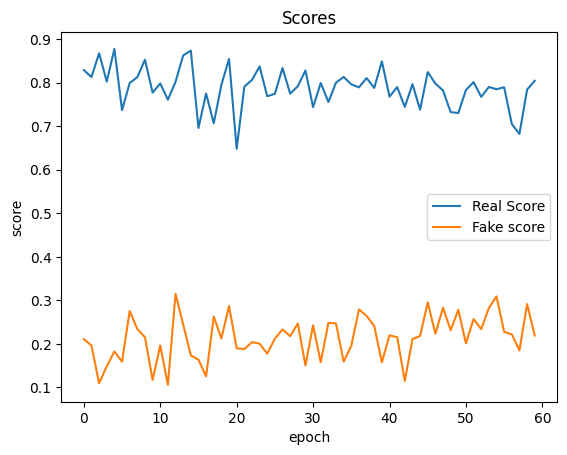

In [58]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [59]:
# Save the model checkpoints
torch.save(G_loaded.state_dict(), 'G_loaded.ckpt')
torch.save(D_loaded.state_dict(), 'D_loaded.ckpt')

In [60]:
D_loaded_2 = D_loaded
D_loaded_2.load_state_dict(torch.load('D_loaded.ckpt'))
D_loaded_2.eval()

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [61]:
G_loaded_2 = G_loaded
G_loaded_2.load_state_dict(torch.load('G_loaded.ckpt'))
G_loaded_2.eval()

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)